## Installing requirements on aws ml.g4dn.12xlarge

In [6]:
pip install -r requirements.txt -q

Note: you may need to restart the kernel to use updated packages.


In [31]:
import os
import pandas as pd
import torchaudio
from torch.utils.data import DataLoader, Dataset
import torch
from transformers import WhisperProcessor, WhisperForConditionalGeneration
import warnings
from tqdm import tqdm
from joblib import Parallel, delayed
import time
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

In [4]:
librispeech_root = ''  # Set this to your LibriSpeech dataset directory
dataset_split = 'dev-clean'
dataset = torchaudio.datasets.LIBRISPEECH(root=librispeech_root, url=dataset_split, download=True)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [7]:
processor = WhisperProcessor.from_pretrained("openai/whisper-tiny")
model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-tiny")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [8]:
# Create a DataFrame to store the dataset information
data = []
for i, (waveform, sample_rate, label, speaker_id, chapter_id, utterance_id) in enumerate(dataset):
    data.append({
        'waveform': waveform,
        'sample_rate': sample_rate,
        'label': label,
        'speaker_id': speaker_id,
        'chapter_id': chapter_id,
        'utterance_id': utterance_id
    })
df = pd.DataFrame(data)

In [9]:
max_length = []
for index, row in df.iterrows():
    waveform = row['waveform'].squeeze(0)
    max_length.append(waveform.shape[0])  
df['length'] = max_length  
df_temp = df[df['length'] < 96000]
sub_df = df_temp.copy()

In [10]:
max_length = 96000
sub_df['waveform'] = sub_df['waveform'].apply(lambda x: torch.nn.functional.pad(x, (0,max_length - x.size(-1)), mode='constant', value = 0))

In [11]:
class SubDataset(Dataset):
    def __init__(self, df):
        self.waveforms = [torch.tensor(x) for x in df['waveform'].tolist()]
        self.labels = df['label'].tolist()

    def __len__(self):
        return len(self.waveforms)

    def __getitem__(self, idx):
        return self.waveforms[idx], self.labels[idx]

In [12]:
sub_dataset = SubDataset(sub_df)

In [13]:
sub_loader = DataLoader(sub_dataset, batch_size=64, shuffle=True)

In [14]:
def process_batch(batch):
    waveforms, labels = batch
    for waveform in waveforms:
        input_features = processor(waveform.squeeze(0).squeeze(0), sampling_rate=16000, return_tensors="pt").input_features
        output_ids = model.generate(input_features, max_length=512, num_beams=4, early_stopping=True, return_dict_in_generate=True, 
                                    output_scores=True, output_hidden_states=True, language='en')
        transcripts = processor.batch_decode(output_ids.sequences, skip_special_tokens=True)
    return transcripts

In [15]:
cpu_count_list = [1,4,8,16,32,48]

In [16]:
time_list=[]

In [17]:
for cpu in tqdm(cpu_count_list):
    start = time.time()
    transcripts = Parallel(n_jobs=cpu)(delayed(process_batch)(batch) for idx, batch in enumerate(sub_loader)) 
    end=time.time()
    time_list.append(end-start)

100%|██████████| 6/6 [17:49<00:00, 178.24s/it]


In [18]:
time_list

[310.23516273498535,
 172.24142408370972,
 144.75248289108276,
 142.91965627670288,
 149.86174368858337,
 149.42646384239197]

In [19]:
serial_time = time_list[0]

In [20]:
serial_time

310.23516273498535

In [24]:
def calculate_speedup(serial_time, parallel_time):
    return serial_time / parallel_time
def calculate_efficiency(speedup, num_cpus):
    return speedup / num_cpus

In [25]:
speedup = [calculate_speedup(serial_time, t) for t in time_list]
efficiency = [calculate_efficiency(s, n) for s, n in zip(speedup, cpu_count_list)]

In [27]:
speedup

[1.0,
 1.8011646407673125,
 2.1432113393759056,
 2.170696255624541,
 2.0701424866619873,
 2.076172819442524]

In [29]:
efficiency

[1.0,
 0.45029116019182813,
 0.2679014174219882,
 0.13566851597653382,
 0.0646919527081871,
 0.043253600405052585]

Text(0.5, 1.0, 'Speedup vs Number of CPUs')

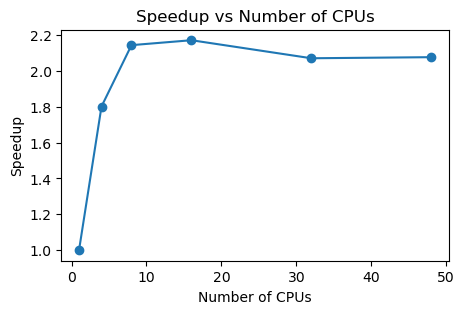

In [34]:
plt.figure(figsize=(5, 3))

plt.plot(cpu_count_list, speedup, marker='o')
plt.xlabel('Number of CPUs')
plt.ylabel('Speedup')
plt.title('Speedup vs Number of CPUs')

Text(0.5, 1.0, 'Efficiency vs Number of CPUs')

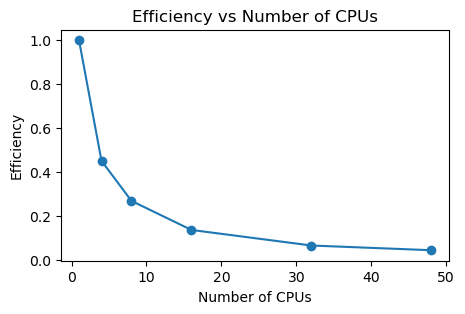

In [35]:
plt.figure(figsize=(5, 3))

plt.plot(cpu_count_list, efficiency, marker='o')
plt.xlabel('Number of CPUs')
plt.ylabel('Efficiency')
plt.title('Efficiency vs Number of CPUs')

In [36]:
# Flatten the list of transcripts
whisper_transcripts = [item for sublist in transcripts for item in sublist]

In [37]:
whisper_transcripts

[' Though not very large, it appeared not likely to be filled for centuries.',
 " I'm a minister of God, sir, and I forbid you to commit this crime.",
 ' Harry gave his farewells with deep and genuine regret.',
 ' I order user NorthKride in Dignit.',
 ' Shall I pour out my soul into the ear of a mist, a fume, from my own brain?',
 ' And then you came back, not caring very much, but it made no difference.',
 ' None of you will be fit for duty tomorrow.',
 " Not one David. That's true love, Christy.",
 ' Oh Bartley, did you write to me?',
 ' It was youth and poverty and proximity, and everything was young and kindly.',
 ' For some reason, the dead at hatchy bridge were not buried.',
 ' Does one Mr. Samuel Basel live here as Travellingin?',
 ' What are two of the musicians from the end of the hall?',
 ' He felt the difference as soon as he reached the hills of his native state.',
 " I'm afraid he said.",
 ' I get nothing but misery out of either.',
 ' And what inquired Mrs. McPherson has 